# SiMFS-Tk Example: Immobilized FRET I

This example demonstrates how to perform simple FRET experiments with SiMFS-Tk.

## Principle

The most basic approach to FRET in SiMFS-Tk is taking a photon emission stream from a fluorophore and split it into to based on a FRET efficiency. For example: With an E-value of 0.5, we split the stream randomly in two, retaining all statistical information about the photon statistics. We can use the ``simfs_spl`` utility to achieve this. A static transfer efficiency is not very interesting, so we add a dynamic conformational change to our system. ``simfs_cnf`` generates a stream of timed vales that are simulated by a transision graph similar to ``simfs_ph2``. The difference is that output events are linked to all nodes, rather than to some edges. In that way we create a stream of transfer efficiency values, that can be used by ``simfs_spl`` as an efficiency input. If the efficiency is high, more photons will be *accepted*, i.e. are transferred. The ``rejected`` output of ``simfs_spl`` represents the photons in the donor channel.  

### Components

- ``simfs_ph2``
- ``simfs_cnf``

### Imports

In [1]:
import os
import numpy as np

from pysimfs import *
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

All simfs components found in /opt/SiMFS-Tk/SiMFS-core/build/src/components/.


### Setting up ``simfs_cnf``

We specify the state system for ``simfs_cnf`` similarly to the ``simfs_ph2`` system. We hace an on and an off rate between two states ``N0`` and ``N1``, each associated with a rate. 
The values linked to the nodes are the transfer efficiencies of the two conformational states. We also set the initial state, an output and an experiment time.

In [2]:
# %simfs_default cnf
states = {
        'on': {
            'from': 'N0',
            'rate': 200.0,
            'to': 'N1'
        },
        'off': {
            'from': 'N1',
            'rate': 100.0,
            'to': 'N0'
        }
    }

values = {
        'N0': 0.3,
        'N1': 0.7
    }   

cnf = Conformation(
    experiment_time=1, 
    states=states, 
    values=values, 
    initial_state='N0', 
    output='FRET_eff.dat'
)

In [3]:
with Simulation() as S:
    S.add(cnf)
    log = S.run()
    E = S.get_results()['FRET_eff.dat']

Folder ./pysimfs_data exists.
Started simulation with 1 component processes.
Simulation completed after 0.03 seconds.


### Inspecting the data

Pysimfs loads the generated data from the simulation files as ``numpy`` arrays with a preset data type.  
Efficiencies from ``simfs_cnf`` are a typed array of ``(v, t)`` tuples. The plot shows the random transition between the two transfer efficiencies of the two conformational states.

Text(0, 0.5, 'FRET efficiency E')

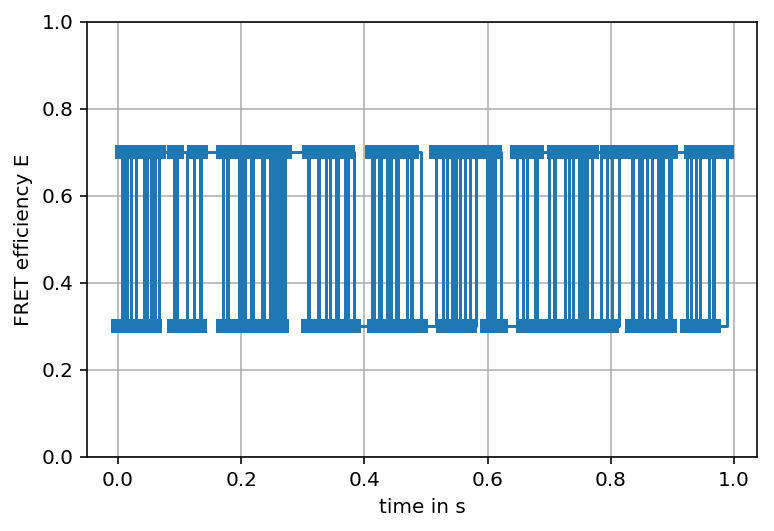

In [4]:
plt.step(E['t'], E['v'], where='post', marker='s')
plt.ylim(0,1)
plt.grid()
plt.xlabel('time in s')
plt.ylabel('FRET efficiency E')

### Putting it together

Now let's connect this to an actual photophysics sumulation. First we setup a standard ``simfs_ph2`` instance with a three state system including a bleaching path to allow termination. We save the bleaching events to a file called ``bleach.dat``. Since bleaching ends the simulation, we expect exactly one value in this file: The end time of the simulation. We use this later to nicely trim our data.

In [5]:
jablonsky = {
        'bleach': {
            'from': 'T1',
            'rate': 1e+3,
            'to': 'X',
            'output': 'bleach.dat'
        },
        'emi': {
            'from': 'S1',
            'output': 'emi',
            'rate': 1e+8,
            'to': 'S0'
        },
        'exi': {
            'from': 'S0',
            'rate': 1e+5,
            'to': 'S1'
        },
        'isc': {
            'from': 'S1',
            'rate': 1e+5,
            'to': 'T1'
        },
        'risc': {
            'from': 'T1',
            'rate': 1e+5,
            'to': 'S0'
        }
    }

ph2 = Fluorophore(
    initial_state='S0', 
    jablonsky=jablonsky
)

We create a new ``simfs_cnf`` instance with a sufficient experiment time.

In [6]:
cnf = Conformation(
    experiment_time=10,
    output='fret_E', 
    states=states, 
    values=values, 
    initial_state='N0'
)

Finally we create a splitter that reads the emission from ``simfs_ph2`` process and the efficiencies from ``simfs_cnf``'s output. The accpeted and rejected outputs are the two photon streams for donor and acceptor.

In [7]:
spl = Splitter(
    photon_input='emi',
    efficiency_input='fret_E',
    accepted_output='Aem.dat',
    rejected_output='Dem.dat'
)

### Running the simulation

In [8]:
with Simulation() as S:
    
    S.add(cnf)
    S.add(ph2)
    S.add(spl)
    
    log = S.run()
    res = S.get_results()

Folder ./pysimfs_data exists.
Started simulation with 3 component processes.
Simulation completed after 0.22 seconds.


We use the bleaching time to trim our data. We then bin it to millisecond bins and plot the timetraces.

In [9]:
bleach = res['bleach.dat'][0]

Dem = res['Dem.dat']
Aem = res['Aem.dat']

# trim to experiment
Dem = Dem[Dem<bleach]
Aem = Aem[Aem<bleach]

In [10]:
t = np.linspace(0, bleach, int(1000*bleach))
histD, _ = np.histogram(Dem, t)
histA, _ = np.histogram(Aem, t)

You can see the alternating states in the photon time trace.

Text(0, 0.5, '# photons per ms')

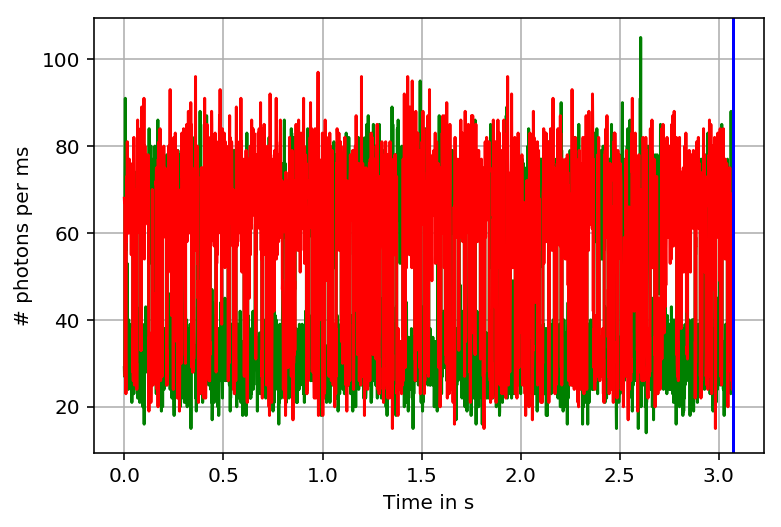

In [11]:
plt.plot(t[:-1], histD, color='g')
plt.plot(t[:-1], histA, color='r')
plt.axvline(bleach, color='b')
plt.grid()

plt.xlabel('Time in s')
plt.ylabel('# photons per ms')

#plt.xlim(0,0.2)

### FRET Histogram

A quick FRET histogram shows the two conformational states.

In [12]:
E = histA/(histA+histD)
histE, binsE = np.histogram(E, np.linspace(0, 1, 50))

Text(0, 0.5, '#')

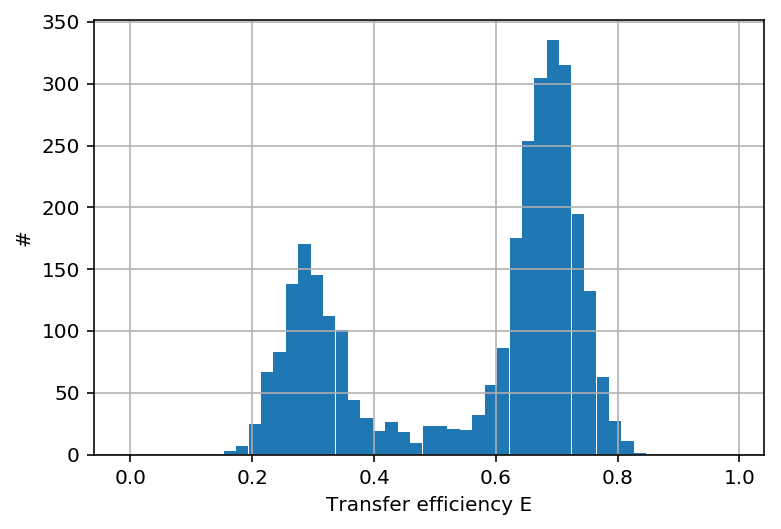

In [13]:
plt.bar(binsE[:-1], histE, width=1/len(binsE))
plt.grid()
plt.xlabel('Transfer efficiency E')
plt.ylabel('#')